1. Importing Libraries and Loading the Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from keras import layers
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv(r"C:\Users\rohit\OneDrive\Desktop\Study IITJ\Projects\Fuel efficiency prediction using tensorflow\auto-mpg.csv")
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


2. Exploratory Data Analysis (EDA)

In [3]:
# Check the shape and general information
df.shape
df.info()
df.describe()

# Check for unique values in 'horsepower'
df['horsepower'].unique()

# Remove rows with missing 'horsepower' data
print(df.shape)
df = df[df['horsepower'] != '?']
print(df.shape)

# Convert 'horsepower' to integer type
df['horsepower'] = df['horsepower'].astype(int)

# Check for missing values
df.isnull().sum()

# Check the number of unique values per column
df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
(398, 9)
(392, 9)


mpg             127
cylinders         5
displacement     81
horsepower       93
weight          346
acceleration     95
model year       13
origin            3
car name        301
dtype: int64

Visualizations

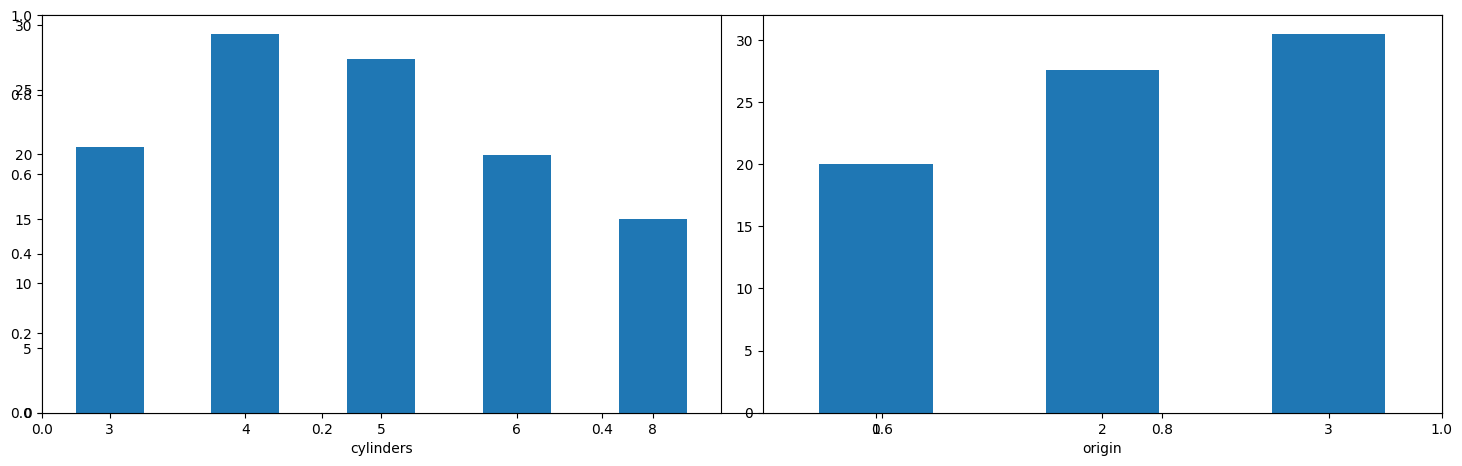

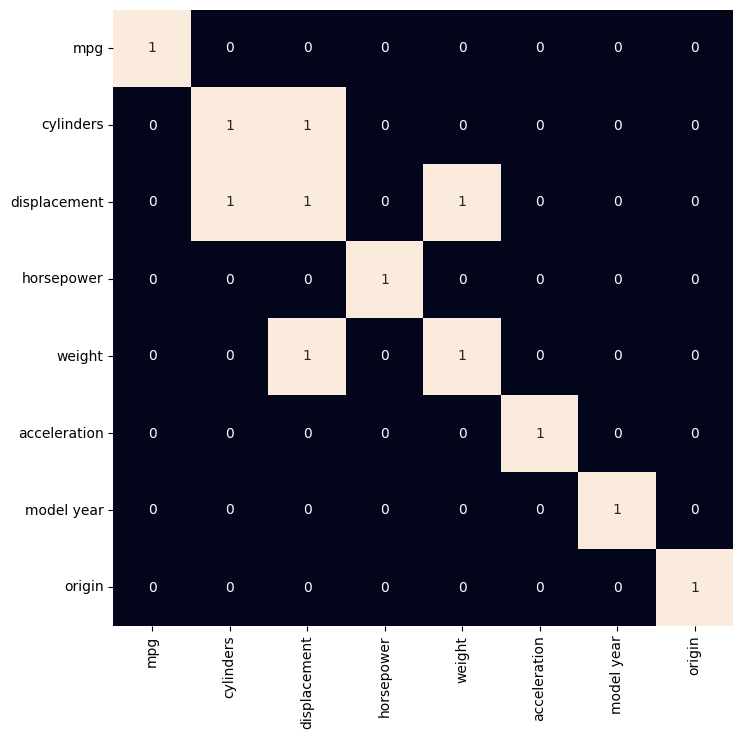

In [4]:
# Bar plots for cylinders and origin
numeric_df = df.select_dtypes(include=['number'])  # Select numeric columns
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = numeric_df.groupby(col).mean()['mpg']
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Heatmap for correlations greater than 0.9
plt.figure(figsize=(8, 8))
sb.heatmap(numeric_df.corr() > 0.9, annot=True, cbar=False)
plt.show()


3. Data Preprocessing


Drop Unnecessary Columns

In [5]:
# Drop 'displacement' and 'car name' columns
df.drop(['displacement', 'car name'], axis=1, inplace=True)


Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Features and target variable
features = df.drop('mpg', axis=1)
target = df['mpg'].values

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)

# Check the shape of the train and validation sets
X_train.shape, X_val.shape


((313, 6), (79, 6))

4. Feature Scaling


In [7]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create TensorFlow datasets for training and validation
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train_scaled, Y_train))
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val_scaled, Y_val))
    .batch(32)
    .prefetch(AUTO)
)


5. Model Building

In [8]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[6]),  # Input layer
    layers.BatchNormalization(),                           # Batch normalization
    layers.Dropout(0.3),                                   # Dropout for regularization
    layers.Dense(128, activation='relu'),                  # Hidden layer 1
    layers.BatchNormalization(),                           # Batch normalization
    layers.Dropout(0.3),                                   # Dropout for regularization
    layers.Dense(64, activation='relu'),                   # Hidden layer 2
    layers.Dense(1, activation='linear')                   # Output layer for regression
])

# Model summary to visualize the layers
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,753 (104.50 KB)

 Trainable params: 26,241 (102.50 KB)

 Non-trainable params: 512 (2.00 KB)

6. Learning Rate Scheduling

In [9]:
# Learning rate scheduling with exponential decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,  # Initial learning rate
    decay_steps=10000,           # Number of steps before decay
    decay_rate=0.9               # Decay rate
)

# Compile the model with Adam optimizer and learning rate scheduling
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='mae',           # Mean Absolute Error (MAE)
    optimizer=optimizer,  # Optimizer with learning rate scheduling
    metrics=['mape']      # Mean Absolute Percentage Error (MAPE)
)


7. Early Stopping

In [10]:
# Implement early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10          # Stop after 10 epochs without improvement
)


8. Model Training

In [11]:
# Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=100,                  # Max epochs
    validation_data=val_ds,       # Validation dataset
    callbacks=[early_stop]        # Early stopping callback
)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 23.8402 - mape: 101.3115 - val_loss: 22.1500 - val_mape: 98.6529
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1676 - mape: 93.4457 - val_loss: 21.7015 - val_mape: 96.2104
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3353 - mape: 84.2158 - val_loss: 21.0130 - val_mape: 92.3202
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0898 - mape: 72.6920 - val_loss: 20.0856 - val_mape: 87.2683
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.7297 - mape: 62.4738 - val_loss: 19.1296 - val_mape: 82.9083
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8556 - mape: 51.1356 - val_loss: 17.9165 - val_mape: 77.9620
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2025 - mape: 37.0110 - val_loss: 16.2701 - val_mape: 71.2766
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4090 - mape: 26.7709 - val_loss: 14.3369 - val_mape: 63.5615
Epoch 9/100
10/1

9. Model Evaluation

In [12]:
# Evaluate the model on validation data
val_loss, val_mape = model.evaluate(val_ds)
print(f"Validation Loss (MAE): {val_loss}")
print(f"Validation MAPE: {val_mape}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1428 - mape: 9.7470
Validation Loss (MAE): 2.404546022415161
Validation MAPE: 10.643625259399414


Additional Evaluation Metrics

In [13]:
# Import metrics to calculate R-squared and Mean Squared Error
from sklearn.metrics import mean_squared_error, r2_score

# Predict on validation data
y_val_pred = model.predict(X_val_scaled)

# Calculate MSE and R-squared
mse = mean_squared_error(Y_val, y_val_pred)
r2 = r2_score(Y_val, y_val_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mean Squared Error (MSE): 12.28523743052898
R-squared: 0.8235284564948109


10. Plotting the Loss and MAPE

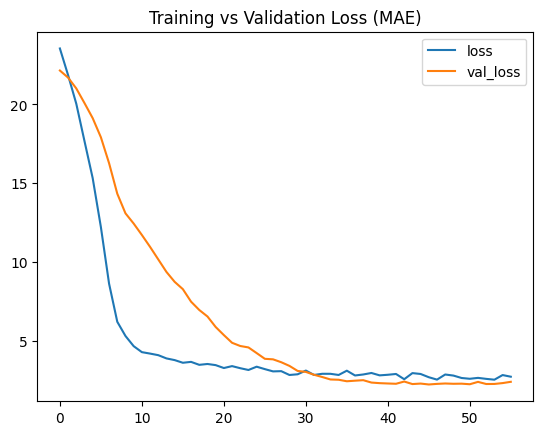

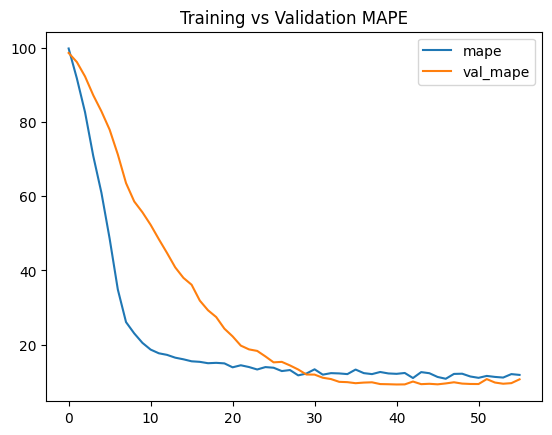

In [14]:
# Convert history to DataFrame for easy plotting
history_df = pd.DataFrame(history.history)

# Plot Loss (MAE) over epochs
history_df.loc[:, ['loss', 'val_loss']].plot(title='Training vs Validation Loss (MAE)')
plt.show()

# Plot MAPE over epochs
history_df.loc[:, ['mape', 'val_mape']].plot(title='Training vs Validation MAPE')
plt.show()
